# Daily vs. Weekly Rebalancing
### By: Carl Farterson
May 8, 2020


## Introduction
When it comes to rebalancing a portfolio, a crucial question to ask is, "how often should my portfolio rebalance?"  
One common theory is, "if trading fees and costs don't exist, the more rebalancing the better!"
LOL.

Unnecessary rebalancing can fuck up your portfolio.
Unnecessary rebalancing can make a trading algorithm less effective.
Unnecessary rebalancing is a common sin.

I will convince you weekly rebalancing may be more effective than daily rebalancing.

This is purely an example and should be treated as such.  It's 2020 and anyone can build and deploy a trading algorithm from their home computer.  Crazy times, huh?

Take this into thought when designing your own trading algorithms.  A trading algorithm
that's "perfect in theory" can also be "horrible in practice".

### Trading Algorithm used
Our trading algo uses three (hourly) moving averages.
- 50
- 100
- 200

- If 50 > 100 > 200, we have a "bullish" signal
- If 50 < 100 < 200, we have a "bearish" signal
- All other times, remain neutral

#### Portfolio allocations
- `bullish`: 90% Ethereum, 10% USD
- `neutral`: 50% Ethereum, 50% USD
- `bearish`: 10% Ethereum, 90% USD

#### Rebalance Intervals
- `D`: daily
- `W`: weekly

### Question: which trading algorithm will have better performance?  Daily or weekly?

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from FART.py.split_df import split_df
from FART.py.simulate import simulate
from FART.py.portfolio import Portfolio

In [3]:
# Variables
assets = ['ETH', 'USD']

# We'll use 180 day windows (6 months) with 120 day overlap (4 months)
# Since our dataframe is in hours, multiply by 24
window_len = 24 * 180
overlap = 24 * 120

allocation = {
    'bull': [0.90, 0.10],
    'neutral': [0.50, 0.50],
    'bear': [0.10, 0.90]
}

wiggle_room = 0.10

volatility_daily = []
volatility_weekly = []
drawdown_daily = []
drawdown_weekly = []
end_pct_daily = []
end_pct_weekly = []
loss_probability_daily = []
loss_probability_weekly = []

df_signals = pd.read_csv('/home/carter/Documents/token-sets/FART/backtests/signals.csv').to_dict(orient='records')

In [4]:
# Helper functions

def calc_volatility(array):
    # Determine 30-day volatility
    # Since we're using hourly data, 24*30 = 720 hours or 30 days

    volatility_lst = []
    
    for i in range(0, len(array), 720):
        volatility = (max(array[i:i+720]) - min(array[i:i+720])) / min(array[i:i+720])
        volatility_lst.append(volatility)
        
    return np.mean(volatility_lst)*100
    

def calc_drawdown(array):
    # At each price, compare the highest past price with the lowest future price
    # to determine the max potential drawdown
    
    drawdown = 0

    for i in range(1, len(array)):
        prev_max = max(array[:i])
        future_min = min(array[i:])

        max_potential_drawdown = (prev_max - future_min) / prev_max

        if max_potential_drawdown > drawdown:
            drawdown = max_potential_drawdown

    return drawdown*100


def calc_end_pct(array):
    # Return % change between start and finish
    
    end_pct = (array[-1] - array[0]) / array[0]
    return end_pct*100


def calc_loss_probability(array):
    # Count how many times our array is worth less than the starting value
    
    loss_count = sum(np.less(array, array[0]))
    loss_probability = loss_count / len(array)
    return loss_probability*100

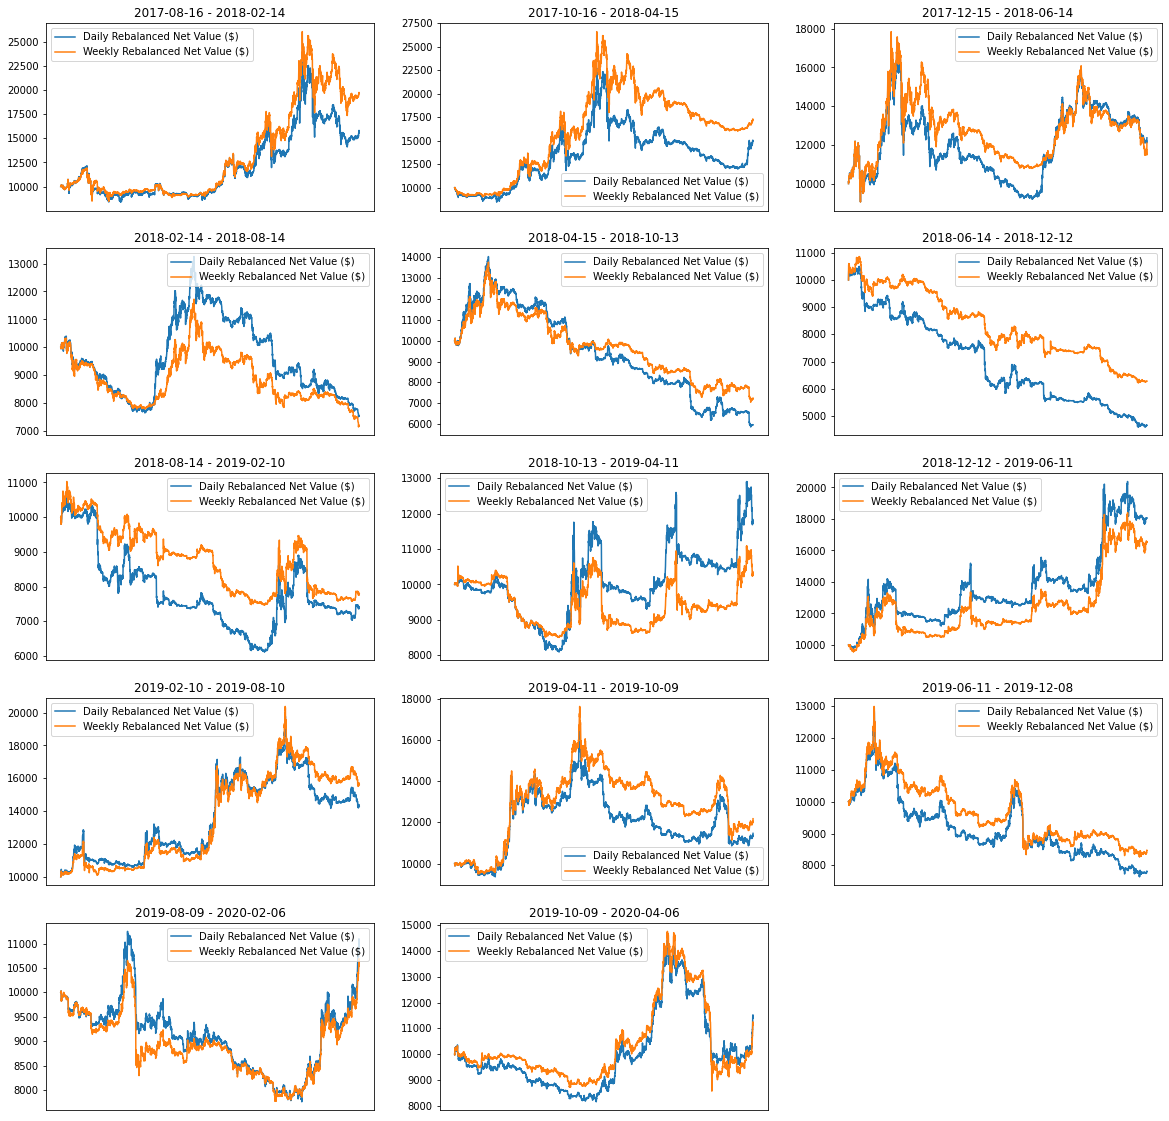

In [5]:
# Display charts

fig = plt.figure(figsize=(20, 20))


for i, df in enumerate(split_df(df_signals, overlap, window_len)):

    daily, _, _ = simulate(assets, allocation, wiggle_room, df, 'daily')
    weekly, _, _ = simulate(assets, allocation, wiggle_room, df, 'weekly')

    # Append calculations
    volatility_daily.append(calc_volatility(daily))
    volatility_weekly.append(calc_volatility(weekly))
    
    drawdown_daily.append(calc_drawdown(daily))
    drawdown_weekly.append(calc_drawdown(weekly))

    end_pct_daily.append(calc_end_pct(daily))
    end_pct_weekly.append(calc_end_pct(weekly))

    loss_probability_daily.append(calc_loss_probability(daily))
    loss_probability_weekly.append(calc_loss_probability(weekly))
    

    df_plot = pd.DataFrame({'Daily Rebalanced Net Value ($)': daily, 'Weekly Rebalanced Net Value ($)': weekly})

    ax = fig.add_subplot(5, 3, i+1)
    ax.plot(df_plot)
    ax.legend(df_plot.columns, loc='best')

    start, end = df[0]['date'][:df[0]['date'].find(' ')], df[-1]['date'][:df[-1]['date'].find(' ')]
    ax.set_title(f"{start} - {end}")
    ax.set_xticks([])

    
plt.show()

In [6]:
# Summary

df_volatility = pd.DataFrame({'Daily': volatility_daily, 'Weekly': volatility_weekly})
print(f'Average Volatility % over 30 days: \n{round(df_volatility.mean(), 2)}\n')

df_drawdown = pd.DataFrame({'Daily': drawdown_daily, 'Weekly': drawdown_weekly})
print(f'Absolute Max Drawdown % over 6 months: \n{round(df_drawdown.max(), 2)}\n')
print(f'Average Max Drawdown % over 6 months: \n{round(df_drawdown.mean(), 2)}\n')

df_end_pct = pd.DataFrame({'Daily': end_pct_daily, 'Weekly': end_pct_weekly})
print(f'Average End Profit % over 6 months: \n{round(df_end_pct.mean(), 2)}\n')

Average Volatility % over 30 days: 
Daily     27.70
Weekly    24.82
dtype: float64

Absolute Max Drawdown % over 6 months: 
Daily     58.21
Weekly    48.77
dtype: float64

Average Max Drawdown % over 6 months: 
Daily     38.90
Weekly    34.47
dtype: float64

Average End Profit % over 6 months: 
Daily     10.44
Weekly    16.13
dtype: float64



## Conclusion
Increasing your rebalance frequency does not necessarily mean better results.  For [FART Set](tokensets.com/set/fart-1), this theory holds true and we have better results rebalancing on a weekly basis than on a daily basis.  bUY SOME FART

https://www.tokensets.com/set/fart-1